In [1]:
import os
import glob
import importlib
import json
import copy

import dill as pkl
import pandas as pd
import psignifit as ps
import matplotlib as mpl
import numpy as np
import scipy as sp
import scipy.stats as spstats

import matplotlib.pyplot as pl
import seaborn as sns
import matplotlib.colors as mcolors


In [2]:

import assign_phase as ph
import utils as util
import process_datafiles as procd
import aggregate_data as aggr

from psignifit import getSigmoidHandle as getSig
from scipy.optimize import curve_fit

In [3]:
def default_options():

    options = {'expType': 'YesNo',
               'sigmoidName': 'gauss',
               'threshPC': 0.5}
    
    return options

def plot_sigmoid_from_params(fit, options, xmin=0, xmax=106, npoints=50, lc='k',
                            lw=1, label=None, ax=None):

    xv, fv = fit_sigmoid(fit, options['sigmoidHandle'], xmin=xmin, xmax=xmax, npoints=npoints)
    
    if ax is None:
        fig, ax = pl.subplots()
        
    ax.plot(xv, fv, c=lc, lw=lw, clip_on=False, label=label)

def fit_sigmoid(fit, fh, xmin=0, xmax=106, npoints=50):

    xv       = np.linspace(xmin, xmax, num=npoints)
    fv   = (1 - fit[2] - fit[3]) * fh(xv,     fit[0], fit[1]) + fit[3]
    
    return xv, fv
    

In [4]:
%matplotlib notebook

In [5]:
# -----------------------------------------------------------------------------
# Plotting:
# -----------------------------------------------------------------------------
import plotting
plotting.set_plot_params()
from plotting import label_figure, get_fig_id

In [6]:
ps.__path__

['/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit']

# data sources

In [7]:
rootdir = '/n/coxfs01/behavior-data'
paradigm = 'threeport'

processed_dir = os.path.join(rootdir, paradigm, 'processed')
metadata = util.get_metadata(paradigm, rootdir=rootdir, filtered=False, create_meta=False)

Loading existing metadata: /n/coxfs01/behavior-data/threeport/metadata.pkl


In [8]:
dst_dir = os.path.join(processed_dir, 'morphs')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

/n/coxfs01/behavior-data/threeport/processed/morphs


In [9]:
# importlib.reload(procd)

In [10]:
#### Get all animals in specified cohorts
cohort_list = ['AG', 'AN']
# cohort_list = ['AG', 'AJ']
excluded_animals = []
cohortdf = procd.combine_cohorts_to_dataframe(metadata, cohorts=cohort_list)

combining data from 2 cohorts: ['AG', 'AN']
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df


In [11]:
_ = ph.print_phase_lookup()

{   -1: 'other',
    0: 'always_reward',
    1: 'default',
    2: 'size',
    3: 'depth_rotation',
    4: 'cross',
    5: 'size_and_depth_rotation',
    6: 'depth_and_planar_rotation',
    7: 'morph',
    8: 'newstimuli',
    9: 'fine_grained_size',
    10: 'fine_grained_depth_rotation',
    11: 'fine_grained_size_and_depth_rotation',
    12: 'transparency',
    13: 'clutter',
    14: 'light_position',
    15: 'x_rotation',
    16: 'position',
    17: 'punishcycle_long',
    18: 'punishcycle_short',
    19: 'no_min_RT'}


In [12]:
#### Select phase to analyze
phase_list = [1, 2, 3, 4, 5, 7] #, 7]

#### Get data for current phase
alldf = aggr.get_cohort_data_by_phase(cohortdf, phase_list=phase_list, cohort_list=cohort_list)


Loading existing metadata: /n/coxfs01/behavior-data/threeport/metadata.pkl
... loading phase data...
/n/coxfs01/behavior-data/threeport/processed/meta/phases_AG.pkl
Loading existing metadata: /n/coxfs01/behavior-data/threeport/metadata.pkl
... loading phase data...
/n/coxfs01/behavior-data/threeport/processed/meta/phases_AN.pkl


In [13]:
#### Assign port mapping to df
portmapping, alldf = aggr.add_portmap(alldf)
for p, plist in portmapping.items():
    print('%s:\n    ' % p, plist)

Object1_Port1:
     ['AN3', 'AN4', 'AN7', 'AN8']
Object1_Port3:
     ['AG1', 'AG10', 'AG11', 'AG2', 'AG3', 'AG4', 'AG5', 'AG6', 'AG7', 'AG8', 'AG9', 'AN1', 'AN2', 'AN5', 'AN6']


In [14]:
#### Get MROPH SESSIONS only
df=alldf[alldf['phase']==7].copy()

transform_names = ['depth_rotation', 'light_position', 'pos_x', 'pos_y', 'rotation', 'size', 'x_rotation']
for t in transform_names:
    print('%s: %i' % (t, len(df[t].unique())))
    
df.head()

depth_rotation: 9
light_position: 1
pos_x: 1
pos_y: 1
rotation: 1
size: 6
x_rotation: 1


,depth_rotation,duration,light_position,name,no_feedback,object,outcome,outcome_time,pos_x,pos_y,...,suffix,time,x_rotation,session,animalid,cohort,sessionid,objectid,phase,portmap
616554,0,466513,None,morph3,False,morph,failure,553034157,0.0,0.0,...,,552598659,None,20160723,AG10,AG,20160723,morph,7,0
616555,-60,799737,None,Blob_N1_CamRot_y-60,False,1,failure,561234544,0.0,0.0,...,,560462673,None,20160723,AG10,AG,20160723,1,7,0
616556,0,1116299,None,Blob_N2_CamRot_y0,False,2,failure,572634479,0.0,0.0,...,,571542396,None,20160723,AG10,AG,20160723,2,7,0
616557,0,1149622,None,morph7,False,morph,failure,588962517,0.0,0.0,...,,587837030,None,20160723,AG10,AG,20160723,morph,7,0
616558,0,549822,None,morph13,False,morph,failure,593994682,0.0,0.0,...,,593468510,None,20160723,AG10,AG,20160723,morph,7,0


In [15]:
#### Assign morphlevel
#morph_images = [f for f in sorted(df['name'].unique()) if 'CamRot_y0' in f and 'Blob_' not in f]
morph_images = [f for f in sorted(df['name'].unique()) if 'morph' in f]

#df['morphlevel'] = [int(n.split('_')[0][5:]) if 'morph' in n else -100 for n in df['name']]
df['morphlevel'] = [int(n.split('_')[0][5:]) if n in morph_images else -100 for n in df['name']]

morphlevels = sorted(df[df['morphlevel']!=-100]['morphlevel'].unique())
min_morph_val, max_morph_val = min(morphlevels), max(morphlevels)
print(min_morph_val, max_morph_val)

df.loc[df['name']=='Blob_N2_CamRot_y0', 'morphlevel'] = 22
df.loc[df['name']=='Blob_N1_CamRot_y0', 'morphlevel'] = 0

morph_df = df[df['morphlevel']!=-100].copy() # Ignore rotation trials
print(df.shape, morph_df.shape)

sorted(morph_df['morphlevel'].unique())


0 20
(116025, 25) (70854, 25)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22]

In [16]:
#### Get counts of each morph level
c_=[]
for animalid, g in morph_df.groupby(['animalid']):

    trialcounts = g['morphlevel'].value_counts().reset_index()\
                    .rename(columns={'morphlevel': 'n_trials', 'index': 'morphlevel'})\
                    .sort_values(by='morphlevel').reset_index(drop=True)
    responses = g.groupby(['morphlevel'])['response'].value_counts().unstack().reset_index()
    outcomes = g.groupby(['morphlevel'])['outcome'].value_counts().unstack().reset_index()
    r = responses.merge(outcomes)
    curr_counts = trialcounts.merge(r)
    
    curr_counts['animalid'] = [animalid for _ in np.arange(0, len(curr_counts))]
    c_.append(curr_counts)
    
counts0 = pd.concat(c_, axis=0).reset_index(drop=True)
counts0['p_correct'] = counts0['success'] / counts0['n_trials']
counts0['ignore'] = counts0['ignore'].fillna(0)

for c in counts0.columns:
    if c in ['animalid']:
        continue
    counts0[c] = counts0[c].astype(float)

counts0.head()

,morphlevel,n_trials,Announce_AcquirePort1,Announce_AcquirePort3,failure,success,animalid,ignore,p_correct
0,0.0,1636.0,526.0,1110.0,526.0,1110.0,AG10,0.0,0.678484
1,1.0,151.0,33.0,118.0,33.0,118.0,AG10,0.0,0.781457
2,2.0,153.0,34.0,119.0,34.0,119.0,AG10,0.0,0.777778
3,3.0,153.0,46.0,107.0,46.0,107.0,AG10,0.0,0.699346
4,4.0,154.0,27.0,127.0,27.0,127.0,AG10,0.0,0.824675


In [17]:
# Some animals need to be remapped
# Announce_AcquirePort1 = Pick Object B
# REV:  Announce_AcquirePort1=Success, AcquirePort2=Failure
reverse_mapping = ['AN3', 'AN4', 'AN7']
mapping = {0: reverse_mapping,
           1: [k for k in df['animalid'].unique() if k not in reverse_mapping]}

In [18]:
counts0['p_chooseB'] = None

for animalid, g in counts0.groupby(['animalid']):

    # check counts
    sum2 = g['Announce_AcquirePort1'] + g['Announce_AcquirePort3']
    sum1 = g['failure'] + g['success'] + g['ignore']
    if not all(sum1==sum2):
        funky_ixs = np.where(sum1!=sum2)[0]
        for i in funky_ixs:
            if animalid in reverse_mapping:
                counts0.loc[g.index[i], 'success'] =  g['Announce_AcquirePort1'].iloc[i]
                counts0.loc[g.index[i], 'failure'] =  g['Announce_AcquirePort3'].iloc[i]
            else:
                counts0.loc[g.index[i], 'success'] =  g['Announce_AcquirePort3'].iloc[i]
                counts0.loc[g.index[i], 'failure'] =  g['Announce_AcquirePort1'].iloc[i]
    #assert all(sum1==sum2), '[%s] bad counts' % animalid
    
    # Identfy port mapping
    portname = 'Announce_AcquirePort3' if animalid in mapping[0] else 'Announce_AcquirePort1'
    #portname = 'Announce_AcquirePort1' if animalid in mapping[0] else 'Announce_AcquirePort3'
    
    ys = g[portname].divide(g['n_trials'])
    counts0.loc[g.index, 'p_chooseB'] = ys.values #g[portname].divide(g['n_trials'])
    
counts0['p_correct'] = counts0['success']/counts0['n_trials']
counts0['n_chooseB'] = counts0['p_chooseB'] * counts0['n_trials']
counts0['n_chooseB'] = counts0['n_chooseB'].astype(int)


In [19]:
counts0[(counts0.animalid=='AG2') & (counts0['morphlevel']==11)]


,morphlevel,n_trials,Announce_AcquirePort1,Announce_AcquirePort3,failure,success,animalid,ignore,p_correct,p_chooseB,n_chooseB
55,11.0,128.0,36.0,92.0,36.0,92.0,AG2,0.0,0.71875,0.28125,36


In [20]:
importlib.reload(aggr)


<module 'aggregate_data' from '/home/julianarhee/Repositories/trainingtracker/three_port/aggregate_data.py'>

In [23]:
#### Look at overall performance for anchors only
anchor_df = df[df['object']!='morph'] #.groupby(['animalid'])['outcome'].value_counts().unstack().reset_index()
anchor_df = aggr.add_train_day(anchor_df)

anchor_counts = aggr.get_counts_from_session_df(anchor_df)

# group_cols = ['animalid']
# group_cols = ['cohort', 'animalid', 'session', 'phase', 'objectid', 'size', 'depth_rotation']
# anchor_counts = df[df['object']!='morph'].groupby(group_cols)['outcome'].value_counts().unstack().reset_index()
# if 'ignore' in anchor_counts:
#     anchor_counts['n_trials'] = anchor_counts['failure']+anchor_counts['success'] + anchor_counts['ignore']
# else:
#     anchor_counts['n_trials'] = anchor_counts['failure']+anchor_counts['success']
# anchor_counts['n_trials'] = anchor_counts['failure']+anchor_counts['success'] 
# anchor_counts['accuracy'] = anchor_counts['success']/anchor_counts['n_trials']

#### Filter out animals that don't pass crit
criterion=0.7
animalids = anchor_counts['animalid'].unique()
mean_acc = anchor_counts.groupby(['animalid']).mean().reset_index()

pass_animals = mean_acc[mean_acc['accuracy']>=criterion]['animalid'].unique()
missing = [k for k in animalids if k not in pass_animals]

print("%i of %i animals pass min crit. %.2f accuracy on anchors. Missing %i:\n  " \
      % (len(pass_animals), len(animalids), criterion, len(missing)), missing)

counts = counts0.copy() #counts0[counts0.animalid.isin(pass_animals)].copy()

10 of 13 animals pass min crit. 0.70 accuracy on anchors. Missing 3:
   ['AG11', 'AG3', 'AN3']


/home/julianarhee/Repositories/trainingtracker/three_port/aggregate_data.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['train_day'] = -1
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


<IPython.core.display.Javascript object>


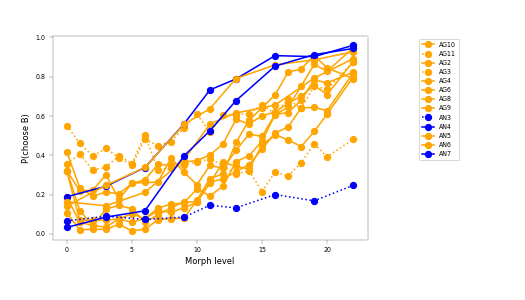

In [24]:
# quick check tha remapped animals aren't extra weird\

color0='blue'
color1='orange'
fig, ax = pl.subplots(figsize=(7,4))
for animalid, g in counts.groupby(['animalid']):

    xs = g['morphlevel'].values 
    ys = g['p_chooseB'].values

    curr_color = color0 if animalid in mapping[0] else color1
    
    ls=':' if animalid in missing else '-'
    ax.plot(xs, ys, label=animalid, color=curr_color,linestyle=ls, marker='o')
    
ax.set_ylabel('P(choose B)')
ax.set_xlabel('Morph level')
ax.legend(bbox_to_anchor=(1.3, 1))
pl.subplots_adjust(left=0.1, right=0.7, bottom=0.2)

In [25]:
counts[counts.isnull().any(axis=1)]

,morphlevel,n_trials,Announce_AcquirePort1,Announce_AcquirePort3,failure,success,animalid,ignore,p_correct,p_chooseB,n_chooseB


In [92]:
#### SAVE.
datafile = os.path.join(dst_dir, 'data_summaries.pkl')

with open(datafile, 'wb') as f:
    pkl.dump(counts, f, protocol=2)

In [33]:
dst_dir

'/n/coxfs01/behavior-data/threeport/processed/morphs'

In [26]:
animalids = counts['animalid'].unique()
color_list = sns.color_palette('cubehelix', n_colors=len(animalids))
animal_colors = dict((k, c) for k, c in zip(animalids, color_list))

<IPython.core.display.Javascript object>


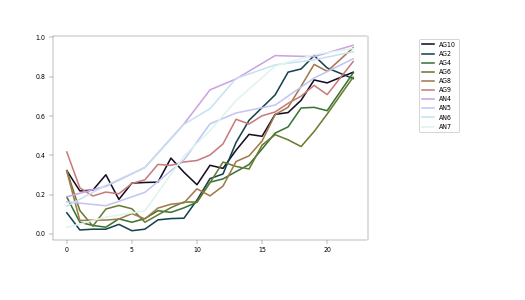

In [27]:
# quick check tha remapped animals aren't extra weird\
fig, ax = pl.subplots(figsize=(7,4))
for animalid, g in counts.groupby(['animalid']):
    if animalid not in pass_animals:
        continue
    
    xs = g['morphlevel'].values 
    ys = g['p_chooseB'].values
    
    ax.plot(xs, ys, label=animalid, color=animal_colors[animalid])
    
ax.legend(bbox_to_anchor=(1.3, 1))
pl.subplots_adjust(left=0.1, right=0.7, bottom=0.2)

In [46]:
len(pass_animals)

10

In [31]:
# # quick check tha remapped animals aren't extra weird\
# fig, ax = pl.subplots(figsize=(7,4))
# for animalid, g in counts.groupby(['animalid']):
#     if animalid not in pass_animals:
#         continue
    
#     xs = g['morphlevel'].values 
#     ys = g['p_correct'].values
    
#     ax.plot(xs, ys, label=animalid, color=animal_colors[animalid])
    
# ax.legend(bbox_to_anchor=(1.3, 1))
# pl.subplots_adjust(left=0.1, right=0.7, bottom=0.2)

# Fits

In [28]:
param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']
n_params = len(param_names)


# Aggregate

In [34]:
datafile = os.path.join(dst_dir, 'data_summaries.pkl')
with open(datafile, 'rb') as f:
    counts = pkl.load(f)
    

In [36]:
if not os.path.exists(os.path.join(dst_dir, 'fits')):
    os.makedirs(os.path.join(dst_dir, 'fits'))
    

In [36]:
counts.head()

,morphlevel,n_trials,Announce_AcquirePort1,Announce_AcquirePort3,failure,success,animalid,ignore,p_correct,p_chooseB,n_chooseB
0,0.0,1636.0,526.0,1110.0,526.0,1110.0,AG10,0.0,0.678484,0.321516,526
1,1.0,151.0,33.0,118.0,33.0,118.0,AG10,0.0,0.781457,0.218543,33
2,2.0,153.0,34.0,119.0,34.0,119.0,AG10,0.0,0.777778,0.222222,34
3,3.0,153.0,46.0,107.0,46.0,107.0,AG10,0.0,0.699346,0.300654,46
4,4.0,154.0,27.0,127.0,27.0,127.0,AG10,0.0,0.824675,0.175325,27


In [37]:
max_x = counts['morphlevel'].max()
xlevels = np.linspace(0, max_x+1) #sorted(counts['morphlevel'].unique())
xlevels

array([ 0.        ,  0.46938776,  0.93877551,  1.40816327,  1.87755102,
        2.34693878,  2.81632653,  3.28571429,  3.75510204,  4.2244898 ,
        4.69387755,  5.16326531,  5.63265306,  6.10204082,  6.57142857,
        7.04081633,  7.51020408,  7.97959184,  8.44897959,  8.91836735,
        9.3877551 ,  9.85714286, 10.32653061, 10.79591837, 11.26530612,
       11.73469388, 12.20408163, 12.67346939, 13.14285714, 13.6122449 ,
       14.08163265, 14.55102041, 15.02040816, 15.48979592, 15.95918367,
       16.42857143, 16.89795918, 17.36734694, 17.83673469, 18.30612245,
       18.7755102 , 19.24489796, 19.71428571, 20.18367347, 20.65306122,
       21.12244898, 21.59183673, 22.06122449, 22.53061224, 23.        ])

<IPython.core.display.Javascript object>


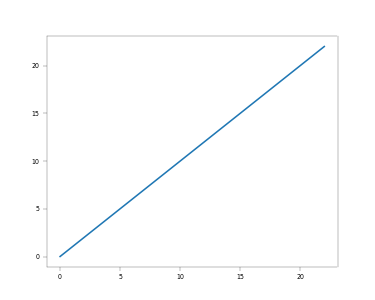

In [38]:
xlevels = np.arange(0, max_x+1)
xlevels / max_x
pl.figure()
pl.plot(xlevels)

In [39]:
counts['morph_percent'] = counts['morphlevel'] / float(max_x)

In [40]:
(counts['morph_percent'].unique())


array([0.        , 0.04545455, 0.09090909, 0.13636364, 0.18181818,
       0.22727273, 0.27272727, 0.31818182, 0.36363636, 0.40909091,
       0.45454545, 0.5       , 0.54545455, 0.59090909, 0.63636364,
       0.68181818, 0.72727273, 0.77272727, 0.81818182, 0.86363636,
       0.90909091, 1.        ])

In [41]:
sigmoid_='gauss'
create_new=True

if create_new:
    opts = dict()
    opts['sigmoidName'] = sigmoid_
    opts['expType'] = 'YesNo' #'2AFC'
    opts['confP'] = np.tile(0.95, n_params)

    results = {}
    d_=[]
    for animalid, g in counts.groupby(['animalid']):
        outfile = os.path.join(dst_dir, 'fits', 'fits_m22-%s_%s.pkl' % (sigmoid_, animalid))
        if os.path.exists(outfile) and create_new is False:
            try:
                print("... opening file")
                with open(outfile, 'rb') as f:
                    res = pkl.load(f)
            except Exception as e:
                create_new=True
                
        if create_new:
            data = g[['morph_percent', 'n_chooseB', 'n_trials']].values
            res = ps.psignifit(data, opts)

            # save
            with open(outfile, 'wb') as f:
                pkl.dump(res, f, protocol=2)
            print(outfile)
            
        df_ = pd.DataFrame(res['Fit'], index=param_names, columns=[animalid]).T
        try:
            thr = ps.getThreshold(res, 0.75)[0] # Value at which function reaches at_pc correct
            slp = ps.getSlope(res, ps.getThreshold(res, 0.75)[0]) # Slope at given stimulus level
        except Exception as e:
            thr=None
            slp=None
            
        [thr_0,CI0] = ps.getThreshold(res,0.25,1)
        [thr_1,CI1] = ps.getThreshold(res,0.75,1)
        jnd = thr_1-thr_0
        df_['jnd'] = jnd
        df_['slope'] = slp
        df_['thr'] = thr
        df_['animalid'] = animalid
        d_.append(df_)

        results[animalid] = res
        print(animalid, res['Fit'].round(2))

    estimates = pd.concat(d_, axis=0)

    est_outfile = os.path.join(dst_dir, 'fitparams_m22-%s.pkl' % sigmoid_)
    with open(est_outfile, 'wb') as f:
        pkl.dump(estimates, f, protocol=2)
    print(est_outfile)

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


/n/coxfs01/behavior-data/threeport/processed/morphs/fits/fits_m22-gauss_AG10.pkl
AG10 [0.72 0.66 0.11 0.26 0.06]


/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:716: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


/n/coxfs01/behavior-data/threeport/processed/morphs/fits/fits_m22-gauss_AG11.pkl
AG11 [0.82 1.09 0.   0.44 0.09]
/n/coxfs01/behavior-data/threeport/processed/morphs/fits/fits_m22-gauss_AG2.pkl
AG2 [0.59 0.41 0.15 0.04 0.09]
/n/coxfs01/behavior-data/threeport/processed/morphs/fits/fits_m22-gauss_AG3.pkl
AG3 [1.12 0.49 0.   0.35 0.  ]
/n/coxfs01/behavior-data/threeport/processed/morphs/fits/fits_m22-gauss_AG4.pkl
AG4 [0.77 0.9  0.   0.07 0.1 ]
/n/coxfs01/behavior-data/threeport/processed/morphs/fits/fits_m22-gauss_AG6.pkl
AG6 [0.83 0.99 0.   0.11 0.16]
/n/coxfs01/behavior-data/threeport/processed/morphs/fits/fits_m22-gauss_AG8.pkl
AG8 [0.71 0.63 0.   0.11 0.13]
/n/coxfs01/behavior-data/threeport/processed/morphs/fits/fits_m22-gauss_AG9.pkl
AG9 [0.72 1.05 0.   0.24 0.11]
/n/coxfs01/behavior-data/threeport/processed/morphs/fits/fits_m22-gauss_AN3.pkl
AN3 [1.38 1.67 0.12 0.06 0.  ]
/n/coxfs01/behavior-data/threeport/processed/morphs/fits/fits_m22-gauss_AN4.pkl
AN4 [0.4  0.78 0.04 0.15 0.  ]

In [354]:
# est_outfile = os.path.join(dst_dir, 'fitparams_m22-%s.pkl' % sigmoid_)
# with open(est_outfile, 'wb') as f:
#     pkl.dump(estimates, f, protocol=2)
# print(est_outfile)

/n/coxfs01/behavior-data/threeport/processed/morphs/fitparams_m22-gauss.pkl


In [48]:
estimates[estimates.animalid.isin(pass_animals)].describe()

,threshold,width,lambda,gamma,eta,jnd,slope,thr
count,10.000000,10.000000,1.000000e+01,10.000000,1.000000e+01,10.000000,10.000000,10.000000
mean,0.616001,0.831366,4.010902e-02,0.112277,6.383415e-02,0.340911,1.094729,0.783041
std,0.165108,0.241038,5.320420e-02,0.086091,5.998429e-02,0.098840,0.250966,0.149512
min,0.338764,0.414378,8.534653e-09,0.000050,1.022693e-08,0.169920,0.837756,0.554059
25%,0.505493,0.657507,4.169347e-07,0.047835,1.574285e-05,0.269618,0.877575,0.660322
50%,0.652060,0.841248,1.757640e-02,0.110194,7.540865e-02,0.344963,1.055324,0.808295
75%,0.723395,1.038289,5.263623e-02,0.142712,1.040424e-01,0.425762,1.267200,0.874589
max,0.830537,1.161862,1.496600e-01,0.261038,1.556324e-01,0.476434,1.575714,1.005614


#### test loading

In [55]:
animalid = "AG2"

outfile = os.path.join(dst_dir, 'fits', 'fits_m22-%s_%s.pkl' % (sigmoid_, animalid))
print(outfile)
with open(outfile, 'rb') as f:
    test = pkl.load(f) #(results, f, protocol=2)
test.keys()

/n/coxfs01/behavior-data/threeport/processed/morphs/fits/fits_m22-gauss_AG2.pkl


dict_keys(['X1D', 'marginals', 'marginalsX', 'marginalsW', 'Posterior', 'logPmax', 'weight', 'integral', 'Fit', 'options', 'data', 'conf_Intervals', 'timestamp'])

In [32]:
importlib.reload(ps.psigniplot)

<module 'psignifit.psigniplot' from '/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py'>

In [33]:
max_x = counts['morph_percent'].max()
xlevels = np.linspace(0, max_x+1) #sorted(counts['morphlevel'].unique())
xlevels

KeyError: 'morph_percent'

In [59]:
# test 1 animal
curr_dst_dir = os.path.join(dst_dir, 'by_animal')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)

<IPython.core.display.Javascript object>


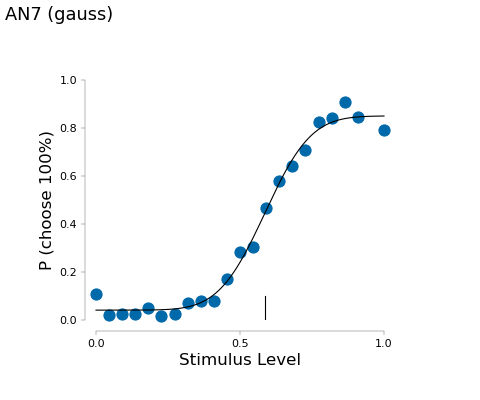

/n/coxfs01/behavior-data/threeport/processed/morphs/by_animal fit_m22-gauss_AN7_pretty2


In [133]:
fig, ax = pl.subplots(figsize=(6,5))
    
ps.psigniplot.plotPsych(test, axisHandle=ax, plotData=True, lineWidth=1, plotAsymptote=False, 
                               thresh_height=0.1, npoints=500, scale_marker=False, markersize=20,
                       tufteAxis=True, extrapolLength=0)
ax.set_xlim([0, max_x])
ax.set_xticks(np.linspace(0, max_x, 3))
pl.subplots_adjust(left=0.2, right=0.8, bottom=0.2, top=0.8)
sns.despine(trim=True, offset=10)
fig.text(0.01, 0.95, '%s (%s)' % (animalid, sigmoid_), fontsize=16)
ax.set_ylabel('P (choose 100%)')


figname = 'fit_m22-%s_%s_pretty2' % (sigmoid_, animalid)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [81]:
importlib.reload(ps.psigniplot)

<module 'psignifit.psigniplot' from '/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py'>

In [74]:
if not os.path.exists(os.path.join(dst_dir, 'figures')):
    os.makedirs(os.path.join(dst_dir, 'figures'))

In [75]:
dst_dir

'/n/coxfs01/behavior-data/threeport/processed/morphs'

<IPython.core.display.Javascript object>


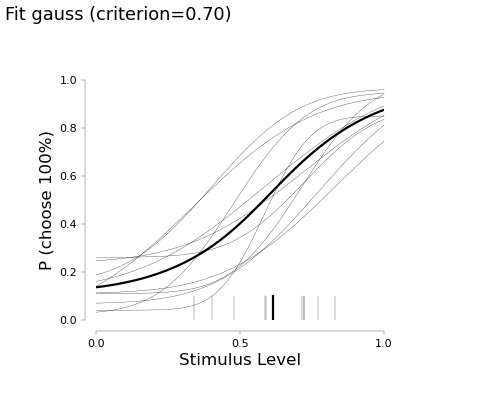

AG10 [0.72 0.66 0.11 0.26 0.06]
AG2 [0.59 0.41 0.15 0.04 0.09]
AG4 [0.77 0.9  0.   0.07 0.1 ]
AG6 [0.83 0.99 0.   0.11 0.16]
AG8 [0.71 0.63 0.   0.11 0.13]
AG9 [0.72 1.05 0.   0.24 0.11]
AN4 [0.4  0.78 0.04 0.15 0.  ]
AN5 [0.59 1.16 0.   0.12 0.  ]
AN6 [0.34 1.07 0.05 0.   0.  ]
AN7 [0.48 0.66 0.05 0.02 0.  ]
/n/coxfs01/behavior-data/threeport/processed/morphs fit_m22-gauss_ALL_crit-0.70_pretty2


In [132]:
mean_color='k'
mean_lw = 2
thresh_height=0.1
npoints=50
opts = default_options()
fitvs=[]

fig, ax = pl.subplots(figsize=(6,5))
for animalid, res in results.items():
    if animalid not in pass_animals:
        continue
    print(animalid, res['Fit'].round(2))
    ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=False, lineWidth=0.25, plotAsymptote=False,
                               thresh_height=thresh_height, npoints=npoints, extrapolLength=0)
    
    fh = getSig.getSigmoidHandle(opts)
    xv, fv = fit_sigmoid(res['Fit'], fh, xmin=0, xmax=max_x)
    fitvs.append(fv)
    
fitvs = np.array(fitvs)
mean_fit = np.mean(fitvs, axis=0)

ax.plot(xv, mean_fit, mean_color, lw=mean_lw)
mean_thr = estimates[estimates.animalid.isin(pass_animals)]['threshold'].mean()
ax.plot([mean_thr, mean_thr], [0, thresh_height], color=mean_color, lw=mean_lw)

# formatting
ax.set_xlim([0, max_x])
ax.set_xticks(np.linspace(0, max_x, 3))
pl.subplots_adjust(left=0.2, right=0.8, bottom=0.2, top=0.8)
sns.despine(trim=True, offset=10)
ax.set_ylabel('P (choose 100%)')
fig.text(0.01, 0.95, 'Fit %s (criterion=%.2f)' % (sigmoid_, criterion), fontsize=16)

figname = 'fit_m22-%s_ALL_crit-%.2f_pretty2' % (sigmoid_, criterion)
pl.savefig(os.path.join(dst_dir, 'figures', '%s.svg' % figname))
print(dst_dir, figname)

<IPython.core.display.Javascript object>


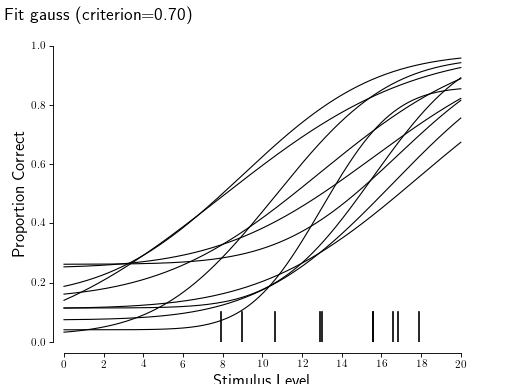

AG10 [16.83 15.37  0.    0.26  0.06]
AG2 [12.98  9.41  0.14  0.04  0.09]
AG4 [16.59 17.65  0.    0.07  0.09]
AG6 [17.87 20.52  0.    0.11  0.16]
AG8 [15.58 12.45  0.    0.11  0.13]
AG9 [15.6  20.1   0.    0.25  0.11]
AN4 [ 8.98 17.28  0.03  0.15  0.  ]
AN5 [12.91 20.59  0.    0.14  0.  ]
AN6 [7.930e+00 2.449e+01 2.000e-02 0.000e+00 0.000e+00]
AN7 [10.64 14.92  0.04  0.02  0.  ]
/n/coxfs01/behavior-data/threeport/processed/morphs/by_animal fit_gauss_ALL_crit-0.70_pretty


In [127]:
fig, ax = pl.subplots()
for animalid, res in results.items():
    if animalid not in pass_animals:
        continue
    print(animalid, res['Fit'].round(2))
    ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=False, lineWidth=1, plotAsymptote=False,
                               thresh_height=0.1, npoints=500, extrapolLength=0)
    
ax.set_xlim([0, max_x])
ax.set_xticks(xlevels[0::2])


sns.despine(trim=True, offset=10)
fig.text(0.01, 0.95, 'Fit %s (criterion=%.2f)' % (sigmoid_, criterion), fontsize=16)

figname = 'fit_m22-%s_ALL_crit-%.2f_pretty' % (sigmoid_, criterion)
pl.savefig(os.path.join(dst_dir, 'figures', '%s.svg' % figname))
print(dst_dir, figname)

In [128]:
len(animalids)

13

<IPython.core.display.Javascript object>


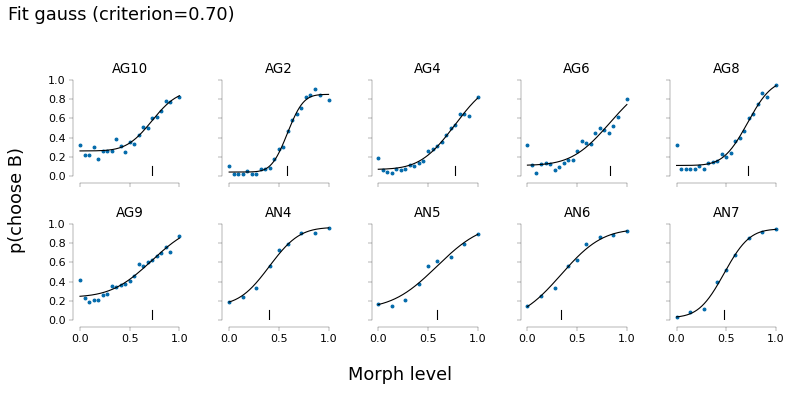

AG10 [0.72 0.66 0.11 0.26 0.06]
AG2 [0.59 0.41 0.15 0.04 0.09]
AG4 [0.77 0.9  0.   0.07 0.1 ]
AG6 [0.83 0.99 0.   0.11 0.16]
AG8 [0.71 0.63 0.   0.11 0.13]
AG9 [0.72 1.05 0.   0.24 0.11]
AN4 [0.4  0.78 0.04 0.15 0.  ]
AN5 [0.59 1.16 0.   0.12 0.  ]
AN6 [0.34 1.07 0.05 0.   0.  ]
AN7 [0.48 0.66 0.05 0.02 0.  ]
/n/coxfs01/behavior-data/threeport/processed/morphs fit_m22-gauss_by_animal__crit-0.70_pretty2


In [84]:
fig, axn = pl.subplots(2,5, figsize=(10, 5), sharex=True, sharey=True)
for ai, (animalid, ax) in enumerate(zip(pass_animals, axn.flat)):
    res = results[animalid]

    print(animalid, res['Fit'].round(2))
    ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=True, lineWidth=1, plotAsymptote=False,
                            thresh_height=0.1, npoints=500, extrapolLength=0,
                            scale_marker=False, markersize=5, tufteAxis=True)
    ax.set_title(animalid, fontsize=12)
    sns.despine(offset=6, trim=True, ax=ax)
    ax.set_ylabel('')
    ax.set_xlabel('')

ax.set_xlim([0, max_x])
ax.set_xticks(np.linspace(0, max_x, 3))

fig.text(0.01, 0.95, 'Fit %s (criterion=%.2f)' % (sigmoid_, criterion), fontsize=16)


fig.text(0.01, 0.5, 'p(choose B)', fontsize=16, va='center', rotation=90)
fig.text(0.5, 0.05, 'Morph level', fontsize=16, ha='center', rotation=0)

    
pl.subplots_adjust(left=0.1, right=0.97, bottom=0.2, top=0.8, wspace=0.5, hspace=0.5)

figname = 'fit_m22-%s_by_animal__crit-%.2f_pretty2' % (sigmoid_, criterion)
pl.savefig(os.path.join(dst_dir, 'figures', '%s.svg' % figname))
print(dst_dir, figname)

In [374]:
xlevels[0::3]

[0.0, 3.0, 6.0, 9.0, 12.0, 15.0, 18.0, 22.0]

In [160]:
animal_colors

{'AG10': (0.08786017593842758, 0.05060928639179554, 0.13064327503162995),
 'AG11': (0.10231025194333628, 0.13952898866828906, 0.2560120319409181),
 'AG2': (0.08362597107228092, 0.2590283754129313, 0.30772816099768746),
 'AG3': (0.10594361078604106, 0.3809739011595331, 0.27015111282899046),
 'AG4': (0.2180922620409734, 0.45605282366093597, 0.20330595171302718),
 'AG6': (0.4106130272672762, 0.48044780541672255, 0.1891154277778484),
 'AG8': (0.6328422475018423, 0.4747981096220677, 0.29070209208025455),
 'AG9': (0.7829183382530567, 0.48158303462490826, 0.48672451968362596),
 'AN3': (0.8334019041992173, 0.5338444716449702, 0.71044264614878),
 'AN4': (0.8046168329276406, 0.6365733569301846, 0.8796578402926125),
 'AN5': (0.7612514532933455, 0.7714053161573218, 0.9520981577613095),
 'AN6': (0.7775608374378459, 0.8840392521212448, 0.9452007992345052),
 'AN7': (0.8708295742505839, 0.957495423037482, 0.9385503293906091)}

In [93]:
counts.head()

,morphlevel,n_trials,Announce_AcquirePort1,Announce_AcquirePort3,failure,success,animalid,ignore,p_correct,p_chooseB,n_chooseB,morph_percent
0,0.0,1636.0,526.0,1110.0,526.0,1110.0,AG10,0.0,0.678484,0.321516,526,0.000000
1,1.0,151.0,33.0,118.0,33.0,118.0,AG10,0.0,0.781457,0.218543,33,0.045455
2,2.0,153.0,34.0,119.0,34.0,119.0,AG10,0.0,0.777778,0.222222,34,0.090909
3,3.0,153.0,46.0,107.0,46.0,107.0,AG10,0.0,0.699346,0.300654,46,0.136364
4,4.0,154.0,27.0,127.0,27.0,127.0,AG10,0.0,0.824675,0.175325,27,0.181818


In [94]:
max_x = float(counts['morph_percent'].max())
print(max_x)
pass_estimates = estimates[(estimates.animalid.isin(pass_animals)) 
                         & (estimates['threshold']>=0) & (estimates['threshold']<=max_x)
                          & (estimates['width']<=max_x)].dropna()


1.0


In [127]:
pass_estimates['animalid'] = pass_estimates['animalid'].astype('category')
pass_estimates.describe().round(3)

,threshold,width,lambda,gamma,eta,slope,thr
count,7.000,7.000,7.000,7.000,7.000,7.000,7.000
mean,0.644,0.719,0.050,0.109,0.076,1.201,0.796
std,0.159,0.192,0.060,0.080,0.060,0.225,0.164
min,0.404,0.414,0.000,0.025,0.000,0.930,0.554
25%,0.532,0.642,0.000,0.055,0.031,1.055,0.684
50%,0.715,0.658,0.035,0.110,0.088,1.124,0.825
75%,0.748,0.841,0.082,0.131,0.113,1.332,0.909
max,0.831,0.994,0.150,0.261,0.156,1.576,1.006


In [129]:
 estimates[(estimates.animalid.isin(pass_animals))].describe().round(3)

,threshold,width,lambda,gamma,eta,slope,thr
count,10.000,10.000,10.000,10.000,10.000,10.000,10.000
mean,0.616,0.831,0.040,0.112,0.064,1.095,0.783
std,0.165,0.241,0.053,0.086,0.060,0.251,0.150
min,0.339,0.414,0.000,0.000,0.000,0.838,0.554
25%,0.505,0.658,0.000,0.048,0.000,0.878,0.660
50%,0.652,0.841,0.018,0.110,0.075,1.055,0.808
75%,0.723,1.038,0.053,0.143,0.104,1.267,0.875
max,0.831,1.162,0.150,0.261,0.156,1.576,1.006


<IPython.core.display.Javascript object>


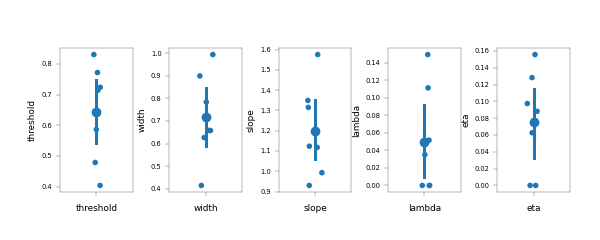

In [122]:
curr_animals = pass_estimates['animalid'].unique()
cols = sns.color_palette('cubehelix', n_colors=len(curr_animals))
animal_colors = dict((k, c) for k, c in zip(curr_animals, cols))


plot_params = ['threshold', 'width', 'slope', 'lambda', 'eta']
fig, axn = pl.subplots(1, len(plot_params), figsize=(len(plot_params)*1.5, 3))
for ax, p in zip(axn.flat, plot_params):
    sns.stripplot(y=p, data=pass_estimates, ax=ax, hue='animalid') #, palette=animal_colors)
    sns.pointplot(y=p, data=pass_estimates, ax=ax) #, palette=animal_colors)

    ax.set_xlabel(p)
#     if p in ['threshold', 'thr', 'width']:
#         ax.set_ylim([0, max_x])
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8, wspace=0.5)

In [109]:
animal_colors

{'AG10': (0.10419418740482515, 0.11632019220053316, 0.2327552016195138),
 'AG2': (0.08523511613408935, 0.32661779003565533, 0.2973201282529313),
 'AG4': (0.26538761550634205, 0.4675654910052002, 0.1908220644759285),
 'AG6': (0.6328422475018423, 0.4747981096220677, 0.29070209208025455),
 'AG8': (0.8306875710682655, 0.5175161303658079, 0.6628221028832032),
 'AN4': (0.7779565181455343, 0.7069421942599752, 0.9314406084043191),
 'AN7': (0.7964528047840354, 0.908668973545918, 0.9398253500983916)}

# Per animal

In [38]:
animalid='AG10' #'AG3'
# animalid='AG2'
sigmoid_ = 'gauss'
g = counts[counts['animalid']==animalid]
# portname = 'Announce_AcquirePort3' if animalid in mapping[0] else 'Announce_AcquirePort1'
# xs = g['morphlevel'].values #if animalid in mapping[0] else g['morphlevel'].values[::-1]
# ys = g[portname].values / g['n_trials'].astype(float).values
# nt = g['n_trials'].values
data = g[['morphlevel', 'n_chooseB', 'n_trials']].values
#data[:, 1] = np.tile(10, len(data))
#data[:, 2] = np.tile(20, len(data))
#data = np.vstack((xs, nt, ys))
#print(xs, ys)

# xmin, xmax = counts['morphlevel'].min(), counts['morphlevel'].max()
# lapse_range = [0.5, 1]
# guess_range = [0, 0.5]
# var_range = [0, 1]
    
# bounds = np.array([[xmin, xmax], [xmin, xmax], lapse_range, guess_range, var_range])
# bounds.shape
# priors = [xmax/2., xmax/2., 0.7, 0.1, 0.5]
data

array([[0.000e+00, 5.260e+02, 1.636e+03],
       [1.000e+00, 3.300e+01, 1.510e+02],
       [2.000e+00, 3.400e+01, 1.530e+02],
       [3.000e+00, 4.600e+01, 1.530e+02],
       [4.000e+00, 2.700e+01, 1.540e+02],
       [5.000e+00, 4.000e+01, 1.550e+02],
       [6.000e+00, 4.000e+01, 1.530e+02],
       [7.000e+00, 4.000e+01, 1.520e+02],
       [8.000e+00, 5.900e+01, 1.530e+02],
       [9.000e+00, 4.700e+01, 1.500e+02],
       [1.000e+01, 3.700e+01, 1.480e+02],
       [1.100e+01, 5.200e+01, 1.490e+02],
       [1.200e+01, 5.000e+01, 1.500e+02],
       [1.300e+01, 6.300e+01, 1.480e+02],
       [1.400e+01, 7.700e+01, 1.520e+02],
       [1.500e+01, 7.500e+01, 1.510e+02],
       [1.600e+01, 1.040e+02, 1.710e+02],
       [1.700e+01, 1.050e+02, 1.700e+02],
       [1.800e+01, 1.170e+02, 1.720e+02],
       [1.900e+01, 1.340e+02, 1.710e+02],
       [2.000e+01, 1.478e+03, 1.807e+03]])

In [39]:
param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']
n_params = len(param_names)

In [40]:
opts = dict()
opts['sigmoidName'] = sigmoid_
opts['expType'] = 'YesNo' #'2AFC'
opts['confP'] = np.tile(0.99, n_params)
#opts['stepN']= [25,20,10,20]  #[40,40,50,20,20]
#  [threshold, width, upper asymptote, lower asymptote, variance scaling] 
# opts['borders'] = bounds
# opts['moveBorders'] = False
# opts['priors'] = priors
res = ps.psignifit(data, opts)
print('Fit:', res['Fit'])


/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Fit: [1.68299877e+01 1.53701699e+01 3.18877063e-10 2.62081925e-01
 6.16854748e-02]


In [35]:
print('Fit:', res['Fit'])

Fit: [1.67949548e+01 1.68258050e+01 6.36616107e-11 2.55660402e-01
 6.37233881e-02]


<IPython.core.display.Javascript object>


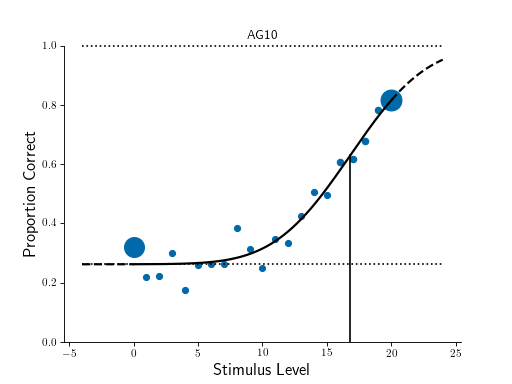

/n/coxfs01/behavior-data/threeport/processed/morphs/by_animal fit_gauss_AG10


In [41]:
fig, ax = pl.subplots()
ps.psigniplot.plotPsych(res, axisHandle=ax)
ax.set_title(animalid)

figname = 'fit_%s_%s' % (sigmoid_, animalid)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


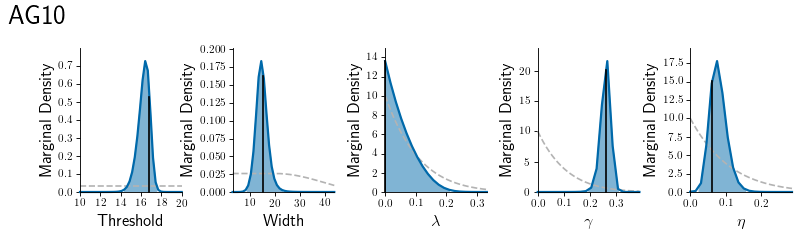

/n/coxfs01/behavior-data/threeport/processed/morphs/by_animal marginals_gauss_AG10


In [42]:
# param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']
#  note that the dashed grey line, which marks the prior goes down where
#  there is still posterior probability. This shows that the prior has an
#  influence on the outcome. 

fig, axn = pl.subplots(1, n_params, figsize=(10,3))

for pi, par in enumerate(param_names):
    ax=axn[pi]
    ax=ps.psigniplot.plotMarginal(res, dim=pi, axisHandle=ax)
pl.subplots_adjust(left=0.1, right=0.99, bottom=0.2, wspace=0.5, top=0.8)

fig.text(0.01, 0.9, animalid, fontsize=24)

figname = 'marginals_%s_%s' % (sigmoid_, animalid)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


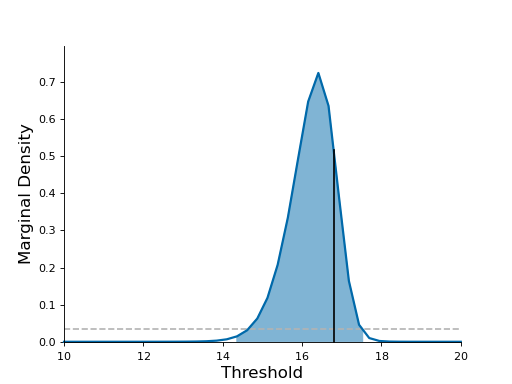

In [36]:
param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']
n_params = len(param_names)

pi = 0
par = param_names[pi]
fig, ax = pl.subplots()

ax=ps.psigniplot.plotMarginal(res, dim=pi, axisHandle=ax)


In [661]:
# D = ps.psignifit getDeviance(res)
def get_deviance(result):
    
    fit = result['Fit']
    data = result['data']
    options = result['options']
    
    stdModel = fit[3] + (1-fit[2]-fit[3]) * options['sigmoidHandle'](data[:,0],fit[0],fit[1])
    deviance = data[:,1]/data[:,2] - stdModel
    stdModel = np.sqrt(stdModel * (1-stdModel))
    deviance = deviance / stdModel
    return deviance

<IPython.core.display.Javascript object>


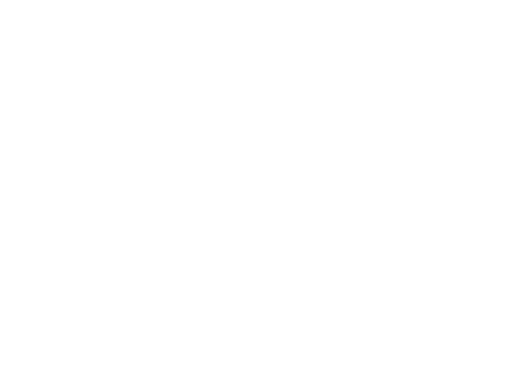

In [662]:
D = get_deviance(res)
D.shape

fig, ax = pl.subplots()
ax.plot(D)
# ax.plot(deviance)

In [663]:
    
def getDeviance(result,Nsamples=None):
    fit = result['Fit']
    data = result['data']
    pPred = fit[3] + (1-fit[2]-fit[3]) * result['options']['sigmoidHandle'](data[:,0], fit[0], fit[1])
    
    pMeasured = data[:,1]/data[:,2]
    loglikelihoodPred = data[:,1]*np.log(pPred)+(data[:,2]-data[:,1])*np.log((1-pPred))
    loglikelihoodMeasured = data[:,1]*np.log(pMeasured)+(data[:,2]-data[:,1])*np.log((1-pMeasured))
    loglikelihoodMeasured[pMeasured==1] = 0;
    loglikelihoodMeasured[pMeasured==0] = 0;

    #devianceResiduals = -2*np.sign(pMeasured-pPred)*(loglikelihoodMeasured - loglikelihoodPred)
    #deviance = np.sum(np.abs(devianceResiduals))
    devianceResiduals = np.sign(pMeasured-pPred)*np.sqrt(2*(loglikelihoodMeasured - loglikelihoodPred))
    deviance = np.sum(devianceResiduals**2)
    
    if Nsamples is None:
        return devianceResiduals,deviance
    else: 
        r_vals=[]
        samples_devianceResiduals = np.zeros((Nsamples,data.shape[0]))
        for iData in range(data.shape[0]):
            samp_dat = np.random.binomial(data[iData,2],pPred[iData],Nsamples)
            #print(samp_dat)
            pMeasured = samp_dat/data[iData,2]
            #print(pMeasured)
            loglikelihoodPred = samp_dat*np.log(pPred[iData])+(data[iData,2]-samp_dat)*np.log(1-pPred[iData])
            loglikelihoodMeasured = samp_dat*np.log(pMeasured)+(data[iData,2]-samp_dat)*np.log(1-pMeasured)
            loglikelihoodMeasured[pMeasured==1] = 0
            loglikelihoodMeasured[pMeasured==0] = 0
            #samples_devianceResiduals[:,iData] = -2*np.sign(pMeasured-pPred[iData])*(loglikelihoodMeasured - loglikelihoodPred)
            samples_devianceResiduals[:,iData] = np.sign(pMeasured-pPred[iData])*np.sqrt(2.*(loglikelihoodMeasured - loglikelihoodPred))
        r_vals=[]
        for iS in range(Nsamples):
            sr = samples_devianceResiduals[iS, :]
            r, p = spstats.pearsonr(sr, pPred)
            r_vals.append(r)
            
        #samples_deviance = np.sum(np.abs(samples_devianceResiduals),axis=1)
        samples_deviance = np.sum(samples_devianceResiduals**2,axis=1)
        return devianceResiduals,deviance,samples_devianceResiduals,samples_deviance, r_vals


In [664]:
def get_empirical_ci(stat, ci=0.95):
    p = ((1.0-ci)/2.0) * 100
    lower = np.percentile(stat, p) #max(0.0, np.percentile(stat, p))
    p = (ci+((1.0-ci)/2.0)) * 100
    upper = np.percentile(stat, p) # min(1.0, np.percentile(x0, p))
    #print('%.1f confidence interval %.2f and %.2f' % (alpha*100, lower, upper))
    return lower, upper

In [665]:
d_resid, d, samples_d_resid, samples_d, r_vals = getDeviance(res, Nsamples=1000)

In [666]:
d_resid.shape, d.shape, samples_d_resid.shape, samples_d.shape

((21,), (), (1000, 21), (1000,))

In [667]:
d, d_resid

(29.56466801535815,
 array([ 0.52165669,  1.18213762, -0.57456807, -0.23781675,  1.03270423,
         0.16404769,  3.20969252, -0.50220924, -0.36037263,  0.05606539,
         0.32155825,  0.6542262 , -0.01719319, -0.9907202 , -0.64763111,
        -3.06991991, -0.82793974, -1.45223141, -0.14341135,  1.24022579,
        -0.13195042]))

In [668]:
assert d == np.sum(d_resid**2)


In [669]:
fit = res['Fit']
data = res['data']
pPred = fit[3] + (1-fit[2]-fit[3]) * res['options']['sigmoidHandle'](data[:,0], fit[0], fit[1])
data_r, data_p = spstats.pearsonr(pPred, d_resid)
ci_lo, ci_hi = get_empirical_ci(r_vals)

<IPython.core.display.Javascript object>


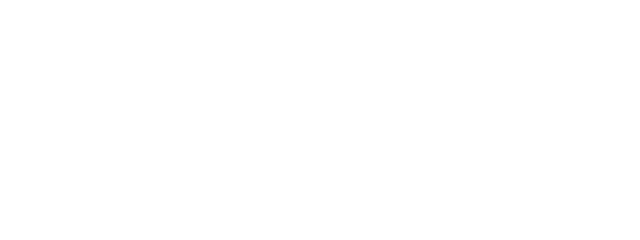

/n/coxfs01/behavior-data/threeport/processed/morphs/by_animal deviance_AG3


In [670]:
col='gray'
fig,axn=pl.subplots(1,3, figsize=(8,3))
ax=axn[0]
sns.histplot(data=samples_d, ax=ax, color=col)
ax.axvline(x=d, color='r')
ax.set_xlabel('deviance')

ax=axn[1]
ax.scatter(pPred, d_resid, label='r=%.2f' % data_r, c=col)
ax.legend()
ax.set_xlabel('prediction')
ax.set_ylabel('deviance residuals')
ax.axhline(y=0.5, color='gray')

ax=axn[2]
sns.histplot(data=r_vals, ax=ax, color=col)
ax.axvline(x=data_r, color='r')
for ci in [ci_lo, ci_hi]:
    ax.axvline(x=ci, color=col, linestyle=':')
ax.set_xlabel('model prediction, r')

pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, wspace=0.5, top=0.8)

fig.text(0.01, 0.9, animalid, fontsize=24)

figname = 'deviance_%s' % animalid
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


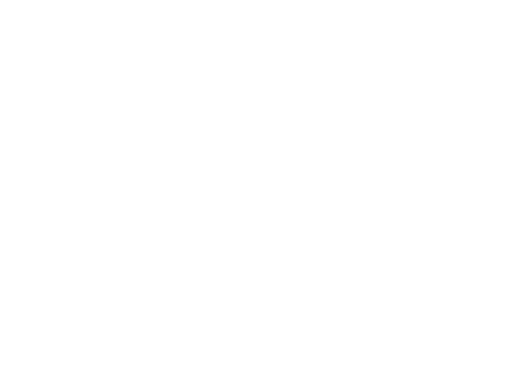

(-5.0, 5.0)

In [308]:
fig, ax = pl.subplots()
ax.plot(d_resid)
ax.plot(samples_d.mean(axis=0))
ax.errorbar(x=np.arange(0, len(d_resid)), y=samples_d.mean(axis=0), yerr=samples_d.std(axis=0))
ax.set_ylim([-5, 5])

In [309]:
samples_d.mean(axis=0).shape

(9,)

In [310]:
samples_d.mean(axis=0)

array([ 0.03998796,  0.21256058,  0.0698094 , -0.01727323,  0.07677449,
        0.09728185,  0.09293462,  0.05331001, -0.06779879])

<IPython.core.display.Javascript object>


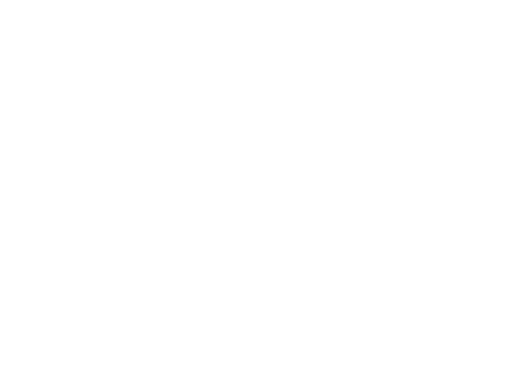

In [479]:
dim = 0
Fit = res['Fit'][dim]

x = res['marginalsX'][dim]
marginal =  res['marginals'][dim]
fig, ax = pl.subplots()
ax.plot(x, marginal)

for ci in res['conf_Intervals'][dim][:, 0]:
    ax.axvline(x=ci, color='k', linestyle=':')
    
ax.plot([Fit,Fit], [0, np.interp(Fit, x, marginal)], 'k', clip_on=False)


<IPython.core.display.Javascript object>


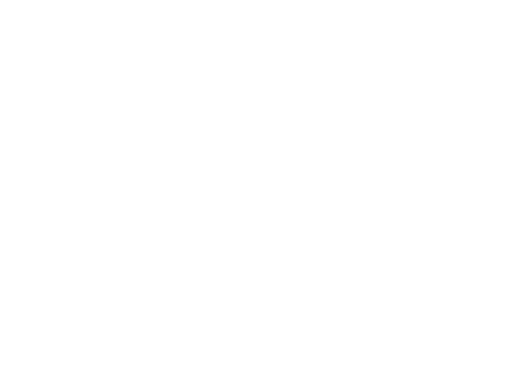

In [481]:

fig, ax = pl.subplots() #pl.figure()
ps.psigniplot.plot2D(res, 1, 0, axisHandle=ax) 

<IPython.core.display.Javascript object>


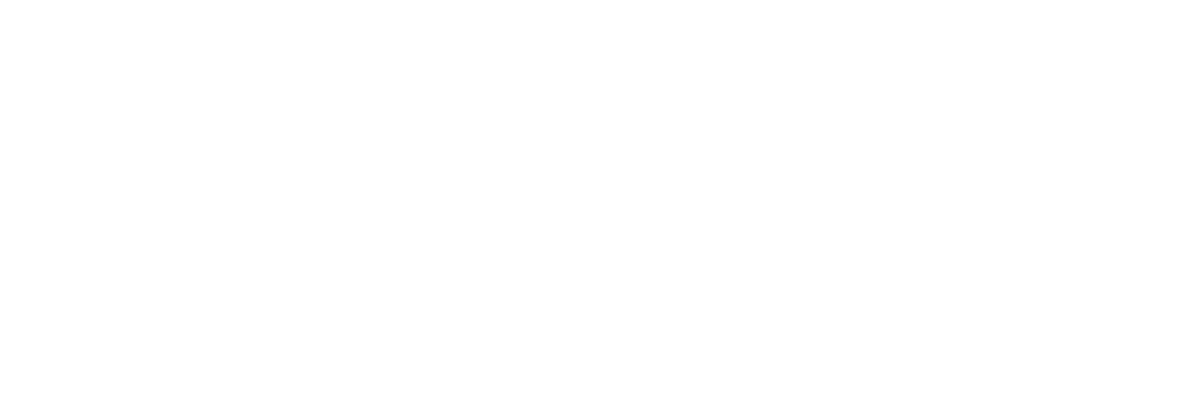

In [293]:
ps.psigniplot.plotsModelfit(res)

## expand stimulus range

In [313]:
opts['stimulusRange'] = np.array([0, 100])
resRange = ps.psignifit(data,opts)

(array([], dtype=int64),)


<IPython.core.display.Javascript object>


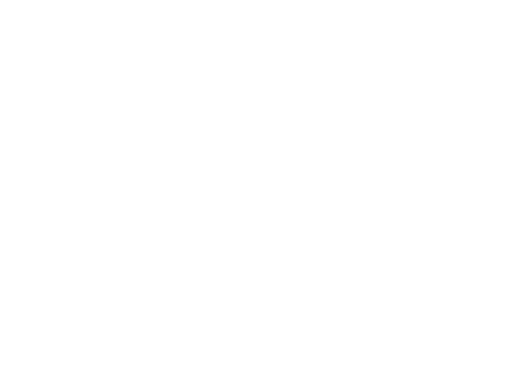

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:443: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,3,4)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:445: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,3,1)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:443: Ma

In [314]:
# We can now have a look how the prior changed:
fig, ax = pl.subplots()
ps.psigniplot.plotPrior(resRange)

<IPython.core.display.Javascript object>


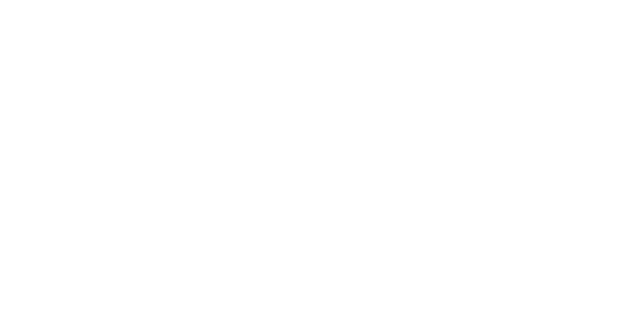

In [315]:
fig, axn = pl.subplots(1,3, figsize=(8,4))
ax=axn[0]
ps.psigniplot.plotPsych(resRange, axisHandle=ax)
ps.psigniplot.plotPsych(res, axisHandle=ax, lineColor=[1, 0, 0],)

ax=axn[1]
ps.psigniplot.plotMarginal(res,0, axisHandle=ax)
ax.set_title("default x-range")

ax=axn[2]
ps.psigniplot.plotMarginal(resRange,0, axisHandle=ax, lineColor=[1,0,0] )
ax.set_title("expanded x-range")

pl.subplots_adjust(left=0.1, right=0.99, wspace=0.5, bottom=0.2)

<IPython.core.display.Javascript object>


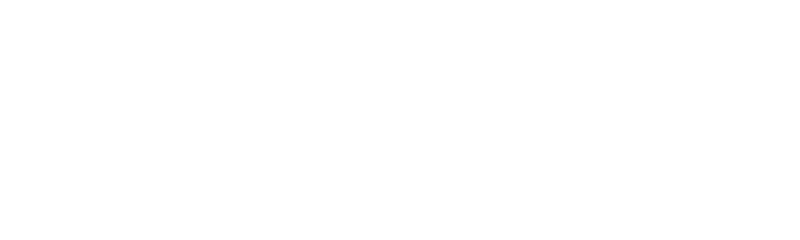

Text(0.01, 0.9, 'AN3')

In [316]:

fig, axn = pl.subplots(1, n_params, figsize=(10,3))

for pi, par in enumerate(param_names):
    ax=axn[pi]
    ax=ps.psigniplot.plotMarginal(resRange, dim=pi, axisHandle=ax)
pl.subplots_adjust(left=0.1, right=0.99, bottom=0.2, wspace=0.5, top=0.8)

fig.text(0.01, 0.9, animalid, fontsize=24)


In [317]:
#first lets have a look at the results with the standard prior strength:
print('Fit:', resRange['Fit'].round(2))
print('confidence Intervals:', resRange['conf_Intervals'].round(2))


Fit: [32.09 47.94  0.    0.05  0.  ]
confidence Intervals: [[[2.4790e+01 2.4790e+01 2.4790e+01 2.4790e+01 2.4790e+01]
  [9.0230e+01 9.0230e+01 9.0230e+01 9.0230e+01 9.0230e+01]]

 [[2.6060e+01 2.6060e+01 2.6060e+01 2.6060e+01 2.6060e+01]
  [1.9503e+02 1.9503e+02 1.9503e+02 1.9503e+02 1.9503e+02]]

 [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
  [3.9000e-01 3.9000e-01 3.9000e-01 3.9000e-01 3.9000e-01]]

 [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
  [1.1000e-01 1.1000e-01 1.1000e-01 1.1000e-01 1.1000e-01]]

 [[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
  [1.9000e-01 1.9000e-01 1.9000e-01 1.9000e-01 1.9000e-01]]]


## fixed priors

In [179]:
import copy

In [180]:
priorLambda = lambda x: ((x>=0)*(x<=.1)).astype('float')

In [181]:

#  Most of the times you then have to adjust the borders of integration as
#  well. This confines the region psignifit operates on. All values outside
#  the borders implicitly have prior probability 0!!
#  For our example we set all borders to NaN, which means they are set
#  automatically and state only the borders for lambda, which is the third
#  parameter. 
    
# To fill the priors field we take the priors from our last fit:
opts2 = copy.deepcopy(res['options'])
# opts2['priors'] = copy.deepcopy(res['options']['priors'])
# opts2['priors'][2] = priorLambda



In [182]:
opts2

{'sigmoidname': 'weibull',
 'expType': 'YesNo',
 'confP': array([0.99, 0.99, 0.99, 0.99, 0.99]),
 'sigmoidName': 'norm',
 'estimateType': 'MAP',
 'instantPlot': 0,
 'maxBorderValue': 1e-05,
 'moveBorders': 1,
 'dynamicGrid': 0,
 'widthalpha': 0.05,
 'threshPC': 0.5,
 'CImethod': 'percentiles',
 'gridSetType': 'cumDist',
 'fixedPars': array([nan, nan, nan, nan, nan]),
 'nblocks': 25,
 'useGPU': 0,
 'poolMaxGap': inf,
 'poolMaxLength': inf,
 'poolxTol': 0,
 'betaPrior': 10,
 'verbose': 0,
 'stimulusRange': array([ 0., 20.]),
 'fastOptim': False,
 'stepN': [40, 40, 20, 20, 20],
 'mbStepN': [25, 30, 10, 10, 15],
 'logspace': 0,
 'widthmin': 1.0,
 'priors': [<function psignifit.priors.normalizeFunction.<locals>.<lambda>(x)>,
  <function psignifit.priors.normalizeFunction.<locals>.<lambda>(x)>,
  <function psignifit.priors.normalizeFunction.<locals>.<lambda>(x)>,
  <function psignifit.priors.normalizeFunction.<locals>.<lambda>(x)>,
  <function psignifit.priors.normalizeFunction.<locals>.<lam

In [189]:
opts2['priors'] = copy.deepcopy(res['options']['priors'])
opts2['priors'][2] = priorLambda

opts2['borders'] = np.nan*np.ones((5,2))
opts2['borders'][2,:]=np.array([0,.1])

opts2['borders'][0,:] = np.array([0, 20])
opts2['borders'][1,:] = np.array([0, 20])

res2 = ps.psignifit(data,opts2)

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/priors.py:145: UserWarning: the prior you provided for lambda returns zeros
  warnings.warn("the prior you provided for %s returns zeros" % parameter)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/utils.py:17: RuntimeWarning: divide by zero encountered in true_divide
  z = (x-mu) /sigma
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/utils.py:17: RuntimeWarning: invalid value encountered in true_divide
  z = (x-mu) /sigma


(array([], dtype=int64),)


/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/likelihood.py:230: RuntimeWarning: divide by zero encountered in log
  prior = np.log(temp)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/likelihood.py:214: RuntimeWarning: divide by zero encountered in log
  prior = np.log(temp)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:276: UserWarning: psignifit:borderWarning
The marginal for the threshold is not near 0 at the upper border.
This indicates that your data is not su

<IPython.core.display.Javascript object>


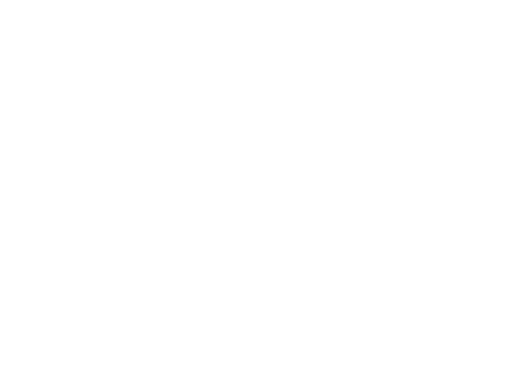

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:443: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,3,4)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:445: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,3,1)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:443: Ma

In [190]:
fig, ax = pl.subplots()
ps.psigniplot.plotPrior(res2)

<IPython.core.display.Javascript object>


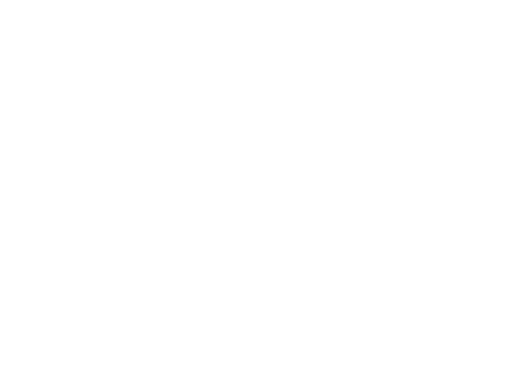

<AxesSubplot:xlabel='Stimulus Level', ylabel='Proportion Correct'>

In [193]:
fig, ax= pl.subplots()
ps.psigniplot.plotPsych(res2)

In [194]:
res2['options']

{'sigmoidname': 'weibull',
 'expType': 'YesNo',
 'confP': array([0.99, 0.99, 0.99, 0.99, 0.99]),
 'sigmoidName': 'norm',
 'estimateType': 'MAP',
 'instantPlot': 0,
 'maxBorderValue': 1e-05,
 'moveBorders': 1,
 'dynamicGrid': 0,
 'widthalpha': 0.05,
 'threshPC': 0.5,
 'CImethod': 'percentiles',
 'gridSetType': 'cumDist',
 'fixedPars': array([nan, nan, nan, nan, nan]),
 'nblocks': 25,
 'useGPU': 0,
 'poolMaxGap': inf,
 'poolMaxLength': inf,
 'poolxTol': 0,
 'betaPrior': 10,
 'verbose': 0,
 'stimulusRange': array([ 0., 20.]),
 'fastOptim': False,
 'stepN': [40, 40, 20, 20, 20],
 'mbStepN': [25, 30, 10, 10, 15],
 'logspace': 0,
 'widthmin': 1.0,
 'priors': [<function psignifit.priors.normalizeFunction.<locals>.<lambda>(x)>,
  <function psignifit.priors.normalizeFunction.<locals>.<lambda>(x)>,
  <function psignifit.priors.normalizeFunction.<locals>.<lambda>(x)>,
  <function psignifit.priors.normalizeFunction.<locals>.<lambda>(x)>,
  <function psignifit.priors.normalizeFunction.<locals>.<lam

<IPython.core.display.Javascript object>


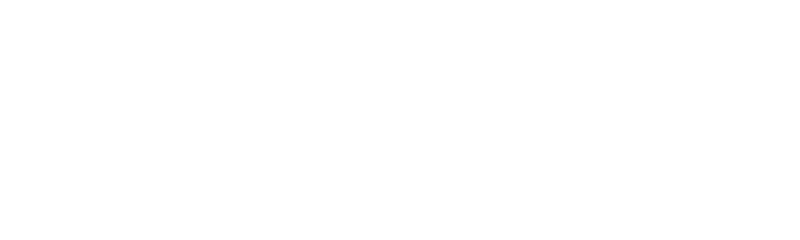

Text(0.01, 0.9, 'AN3')

In [195]:

fig, axn = pl.subplots(1, n_params, figsize=(10,3))

for pi, par in enumerate(param_names):
    ax=axn[pi]
    ax=ps.psigniplot.plotMarginal(res2, dim=pi, axisHandle=ax)
pl.subplots_adjust(left=0.1, right=0.99, bottom=0.2, wspace=0.5, top=0.8)

fig.text(0.01, 0.9, animalid, fontsize=24)


In [199]:
#first lets have a look at the results with the standard prior strength:
print('Fit:', res2['Fit'].round(2))
print('confidence Intervals:', res2['conf_Intervals'].round(2))

Fit: [27.34 29.69  0.06  0.07  0.  ]
confidence Intervals: [[[17.98 17.98 17.98 17.98 17.98]
  [20.   20.   20.   20.   20.  ]]

 [[ 1.51  1.51  1.51  1.51  1.51]
  [19.92 19.92 19.92 19.92 19.92]]

 [[ 0.    0.    0.    0.    0.  ]
  [ 0.1   0.1   0.1   0.1   0.1 ]]

 [[ 0.03  0.03  0.03  0.03  0.03]
  [ 0.2   0.2   0.2   0.2   0.2 ]]

 [[ 0.15  0.15  0.15  0.15  0.15]
  [ 0.45  0.45  0.45  0.45  0.45]]]


In [147]:
# Value at which function reaches 50% correct
ps.getThreshold(res, 0.5)


/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


(13.411669543470857,
 array([[11.99879725, 15.68942297],
        [11.99879725, 15.68942297],
        [11.99879725, 15.68942297],
        [11.99879725, 15.68942297],
        [11.99879725, 15.68942297]]))

In [148]:
ps.getThreshold(res, 0.5, 1)

(12.981653368493864,
 array([[12.16869145, 14.24501239],
        [12.16869145, 14.24501239],
        [12.16869145, 14.24501239],
        [12.16869145, 14.24501239],
        [12.16869145, 14.24501239]]))

In [149]:
ps.getSlope(res,13.4)


0.11322684473266799

In [150]:
ps.getSlopePC(res, 0.5)

0.11315842786489096

In [153]:
ps.psigniplot.getStandardParameters(res)

AttributeError: module 'psignifit.psigniplot' has no attribute 'getStandardParameters'

<IPython.core.display.Javascript object>


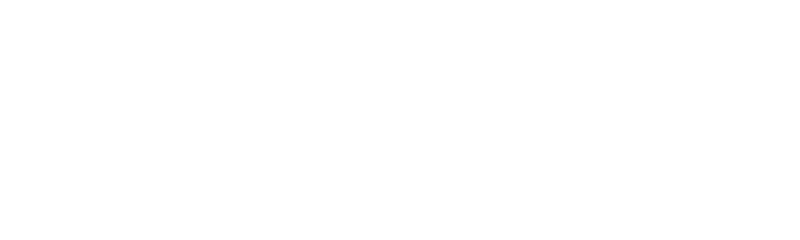

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:443: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,3,4)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:445: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,3,1)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:443: Ma

In [152]:
fig, axn = pl.subplots(2, n_params, figsize=(10,3))

ps.psigniplot.plotPrior(res ) #,axisHandle=ax)